<a href="https://colab.research.google.com/github/04-purnima/Appliances-Energy-Prediction/blob/main/Purnima__Appliances_Energy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#date time year-month-day hour:minute:second
#Appliances, energy use in Wh (Dependent variable)
#lights, energy use of light fixtures in the house in Wh (Drop this column)
#T1, Temperature in kitchen area, in Celsius
#RH1, Humidity in kitchen area, in %
#T2, Temperature in living room area, in Celsius
#RH2,Humidity in living room area, in %
#T3, Temperature in laundry room area
#RH3, Humidity in laundry room area, in %
#T4, Temperature in office room, in Celsius
#RH4,Humidity in office room, in %
#T5, Temperature in bathroom, in Celsius
#RH5, Humidity in bathroom, in %
#T6, Temperature outside the building (north side), in Celsius
#RH6, Humidity outside the building (north side), in %
#T7, Temperature in ironing room , in Celsius
#RH7, Humidity in ironing room, in %
#T8, Temperature in teenager room 2, in Celsius
#RH8,Humidity in teenager room 2, in %
#T9, Temperature in parents room, in Celsius
#RH9, Humidity in parents room, in %
#To, Temperature outside (from Chievres weather station), in Celsius
#Pressure (from Chievres weather station), in mm Hg RHout,
#Humidity outside (from Chievres weather station), in %
#Wind speed (from Chievres weather station), in m/s
#Visibility (from Chievres weather station), in km
#Tdewpoint (from Chievres weather station), Â°C
#rv1, Random variable 1, nondimensional
#rv2, Random variable 2, nondimensional

In [70]:
#IMPORTING LIBRARIES
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import math
import time
from math import sqrt

from datetime import datetime
import dateutil
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
import xgboost as xgb

!pip3 install catboost
from catboost import CatBoostRegressor as cbr
from sklearn import neighbors
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn import preprocessing, model_selection, metrics
from sklearn.metrics import mean_squared_error, r2_score

In [71]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [72]:
file_path = ('/content/drive/MyDrive/Almabetter Notebooks/Capstone(Regression)/Data/data_application_energy.csv')
ae_df = pd.read_csv(file_path)

#Data Exploration

In [73]:
ae_df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [74]:
ae_df.shape

(19735, 29)

In [75]:
ae_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         19735 non-null  object 
 1   Appliances   19735 non-null  int64  
 2   lights       19735 non-null  int64  
 3   T1           19735 non-null  float64
 4   RH_1         19735 non-null  float64
 5   T2           19735 non-null  float64
 6   RH_2         19735 non-null  float64
 7   T3           19735 non-null  float64
 8   RH_3         19735 non-null  float64
 9   T4           19735 non-null  float64
 10  RH_4         19735 non-null  float64
 11  T5           19735 non-null  float64
 12  RH_5         19735 non-null  float64
 13  T6           19735 non-null  float64
 14  RH_6         19735 non-null  float64
 15  T7           19735 non-null  float64
 16  RH_7         19735 non-null  float64
 17  T8           19735 non-null  float64
 18  RH_8         19735 non-null  float64
 19  T9  

In [76]:
temp_dict = {
    'T1' : 'kitchen_temp', 'T2' : 'living_temp', 'T3' : 'laundry_temp', 
    'T4' : 'office_temp', 'T5' : 'bath_temp', 'T6' : 'outside_temp',
    'T7' : 'ironing_temp', 'T8' : 'teen_temp', 'T9' : 'parents_temp', 'T_out' : 'station_temp'
}

In [77]:
energy_df = ae_df.rename(columns=temp_dict)

In [78]:
humid_dict = {
    'RH_1' : 'kitchen_humid', 'RH_2' : 'living_humid', 'RH_3' : 'laundry_humid', 
    'RH_4' : 'office_humid', 'RH_5' : 'bath_humid', 'RH_6' : 'outside_humid',
    'RH_7' : 'ironing_humid', 'RH_8' : 'teen_humid', 'RH_9' : 'parents_humid', 'RH_out' : 'station_humid'
}

In [79]:
energy_df = energy_df.rename(columns=humid_dict)

In [80]:
energy_df[temp_dict.values()].describe()

,kitchen_temp,living_temp,laundry_temp,office_temp,bath_temp,outside_temp,ironing_temp,teen_temp,parents_temp,station_temp
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,21.686571,20.341219,22.267611,20.855335,19.592106,7.910939,20.267106,22.029107,19.485828,7.411665
std,1.606066,2.192974,2.006111,2.042884,1.844623,6.090347,2.109993,1.956162,2.014712,5.317409
min,16.790000,16.100000,17.200000,15.100000,15.330000,-6.065000,15.390000,16.306667,14.890000,-5.000000
25%,20.760000,18.790000,20.790000,19.530000,18.277500,3.626667,18.700000,20.790000,18.000000,3.666667
50%,21.600000,20.000000,22.100000,20.666667,19.390000,7.300000,20.033333,22.100000,19.390000,6.916667
75%,22.600000,21.500000,23.290000,22.100000,20.619643,11.256000,21.600000,23.390000,20.600000,10.408333
max,26.260000,29.856667,29.236000,26.200000,25.795000,28.290000,26.000000,27.230000,24.500000,26.100000


OBSERVATIONS :

1.Average outside temperature over a period of 4.5 months is around 7.5 degrees. It ranges from -6 to 28 degrees

2.While average temperature inside the building has been around 20 degrees for all the rooms. It ranges from 14 - 30 degrees

3.Which implies, Warming appliances have been used to keep the insides of the building warm. There must be some sort of direct correlation between temperature and consumption of energy inside house.

In [81]:
energy_df[humid_dict.values()].describe()

,kitchen_humid,living_humid,laundry_humid,office_humid,bath_humid,outside_humid,ironing_humid,teen_humid,parents_humid,station_humid
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,40.259739,40.420420,39.242500,39.026904,50.949283,54.609083,35.388200,42.936165,41.552401,79.750418
std,3.979299,4.069813,3.254576,4.341321,9.022034,31.149806,5.114208,5.224361,4.151497,14.901088
min,27.023333,20.463333,28.766667,27.660000,29.815000,1.000000,23.200000,29.600000,29.166667,24.000000
25%,37.333333,37.900000,36.900000,35.530000,45.400000,30.025000,31.500000,39.066667,38.500000,70.333333
50%,39.656667,40.500000,38.530000,38.400000,49.090000,55.290000,34.863333,42.375000,40.900000,83.666667
75%,43.066667,43.260000,41.760000,42.156667,53.663333,83.226667,39.000000,46.536000,44.338095,91.666667
max,63.360000,56.026667,50.163333,51.090000,96.321667,99.900000,51.400000,58.780000,53.326667,100.000000


OBSERVATIONS :

1.Average humidity outside the building has been higher than the average humidity inside.

2.Average humidity at the weather station is significantly higher compared to outside humidity near the building.

3.Average humidity in the bathroom is significantly higher compared to other rooms due to obvious reasons.

4.Kids and parent room show a comparatively higher average humidity as well signifying the fact that, inhabitants of this building spend most of their time in these buildings.

In [82]:
weather_cols = list(set(energy_df.columns) - set(list(temp_dict.values())) - set(list(humid_dict.values())) - {'Appliances', 'lights', 'rv1', 'rv2'})
weather_cols

['Tdewpoint', 'date', 'Visibility', 'Windspeed', 'Press_mm_hg']

Distribution of our appliances energy usage :

In [83]:
ae_df.Appliances.describe()

count    19735.000000
mean        97.694958
std        102.524891
min         10.000000
25%         50.000000
50%         60.000000
75%        100.000000
max       1080.000000
Name: Appliances, dtype: float64

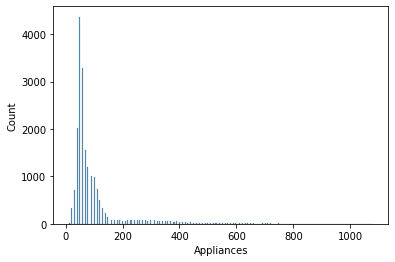

In [84]:
sns.histplot(ae_df['Appliances'])

75% of Appliance consumption is less than 100 Wh . With the maximum consumption of 1080 Wh , there will be outliers in this column and there are small number of cases where consumption is very high.

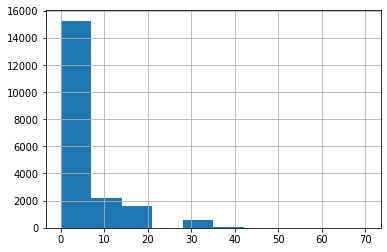

In [85]:
ae_df.lights.hist(bins=10)


In [86]:
ae_df.lights.value_counts()

0     15252
10     2212
20     1624
30      559
40       77
50        9
60        1
70        1
Name: lights, dtype: int64

Since most of the value in lights column is 0, it wont be playing much role in our model. Hence we drop the lights feature from our dataframe.

In [87]:
energy_df= energy_df.drop('lights', axis=1)

#Energy consumption


In [88]:
energy_df['weekday'] = ((pd.to_datetime(energy_df['date']).dt.dayofweek)// 5 == 0).astype(int)
energy_df['hour'] = pd.to_datetime(energy_df['date']).dt.hour
energy_df['month'] = pd.to_datetime(energy_df['date']).dt.month

Text(0, 0.5, 'Appliance energy (Wh)')

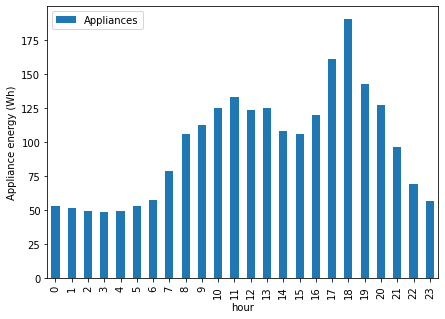

In [89]:
fig, ax = plt.subplots(1,1,figsize=(7,5))
energy_df.groupby('hour').agg({'Appliances' : 'mean'}).plot.bar(ax=ax)
ax.set_ylabel('Appliance energy (Wh)')

Text(0, 0.5, 'Appliance enrergy (Wh)')

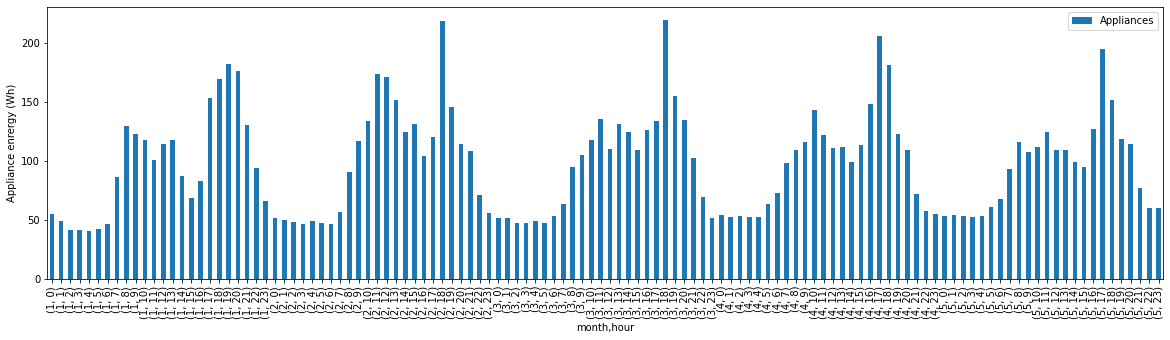

In [90]:
fig, ax = plt.subplots(1,1,figsize=(20,5))
energy_df.groupby(['month','hour']).agg({'Appliances' : 'mean'}).plot.bar(ax=ax)
ax.set_ylabel('Appliance enrergy (Wh)')

Text(0, 0.5, 'Appliance Energy (Wh)')

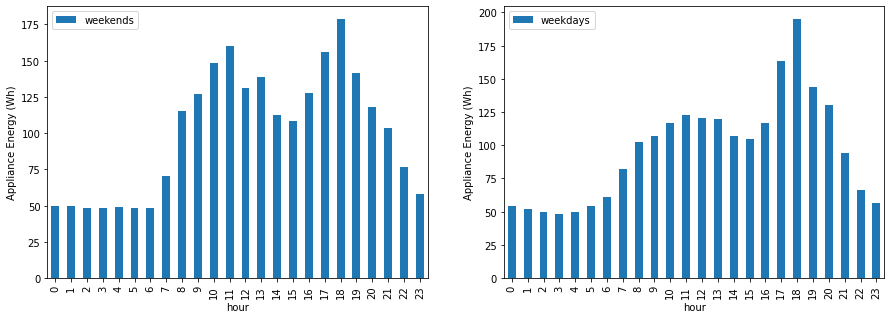

In [91]:
#What about weekdays and weekends?
fig, ax = plt.subplots(1,2,figsize=(15,5))
week_df = energy_df.groupby(['weekday','hour']).agg({'Appliances':'mean'}).reset_index(0)
week_df[week_df.weekday==0].Appliances.plot.bar(ax=ax[0], label='weekends')
week_df[week_df.weekday==1].Appliances.plot.bar(ax=ax[1], label='weekdays')
ax[0].legend(loc='best')
ax[1].legend(loc='best')
ax[0].set_ylabel('Appliance Energy (Wh)')
ax[1].set_ylabel('Appliance Energy (Wh)')

#Temperature levels

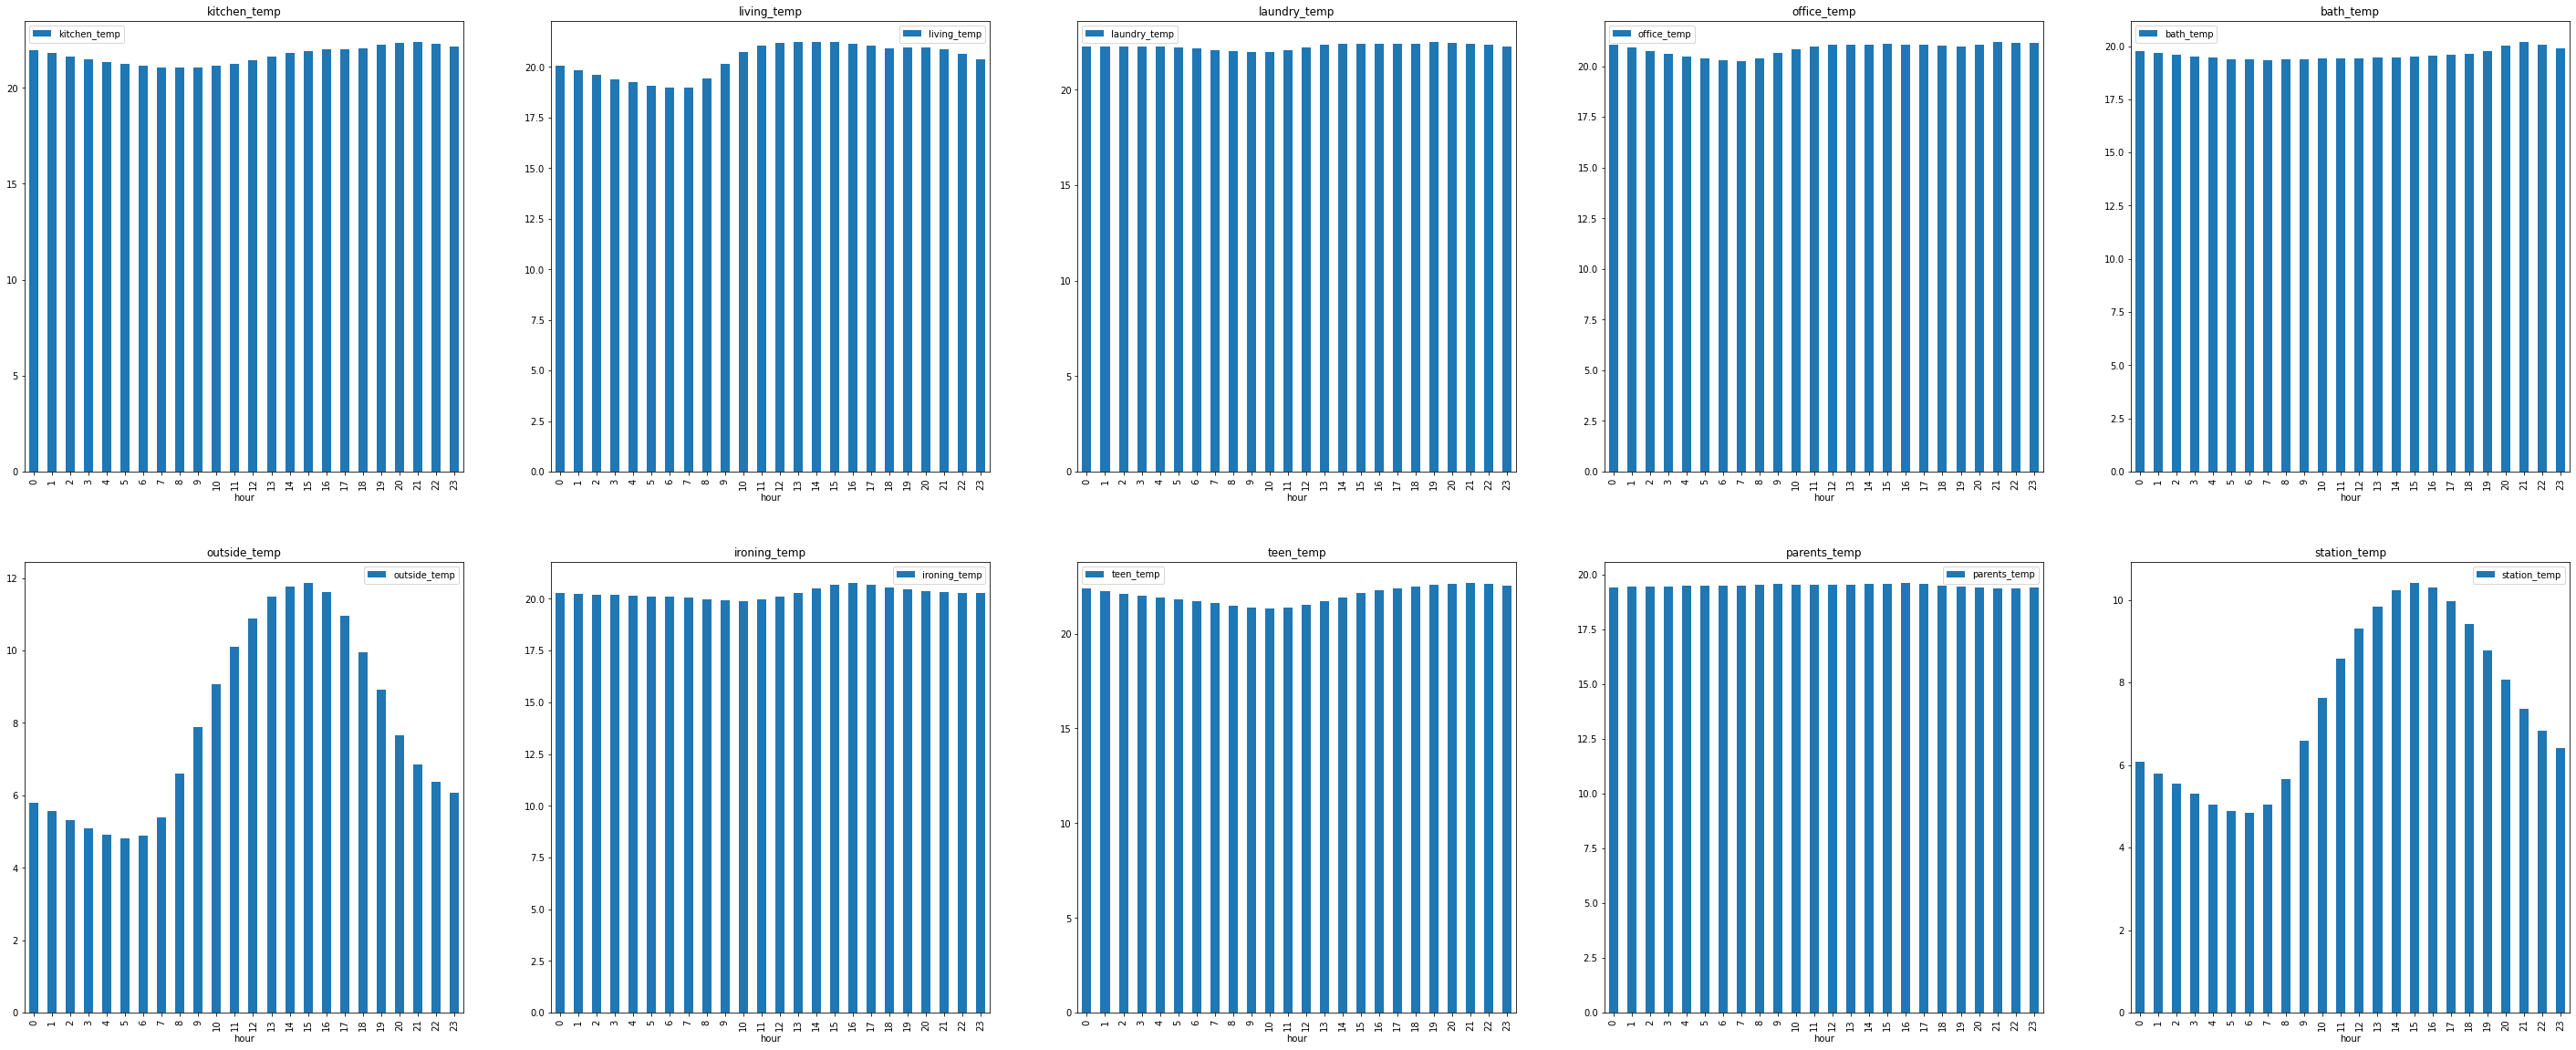

In [28]:
fig, axes = plt.subplots(2,5,figsize=(50,20))
for i, temp in enumerate(temp_dict.values()):
  energy_df.groupby('hour').agg({temp : 'mean'}).plot.bar(ax=axes[i//5, i%5])
  axes[i//5, i%5].legend(loc='best')
  axes[i//5, i%5].set_title(temp)

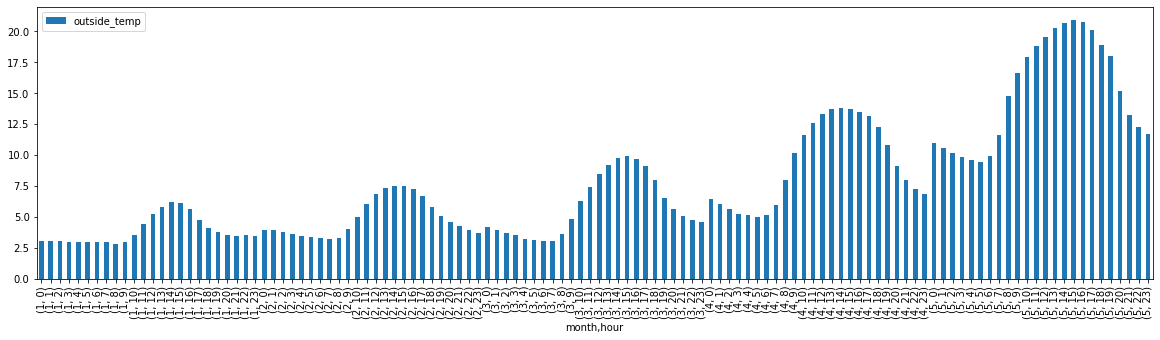

In [29]:
fig, ax = plt.subplots(1,1,figsize=(20,5))
energy_df.groupby(['month','hour']).agg({'outside_temp' : 'mean'}).plot.bar(ax=ax)

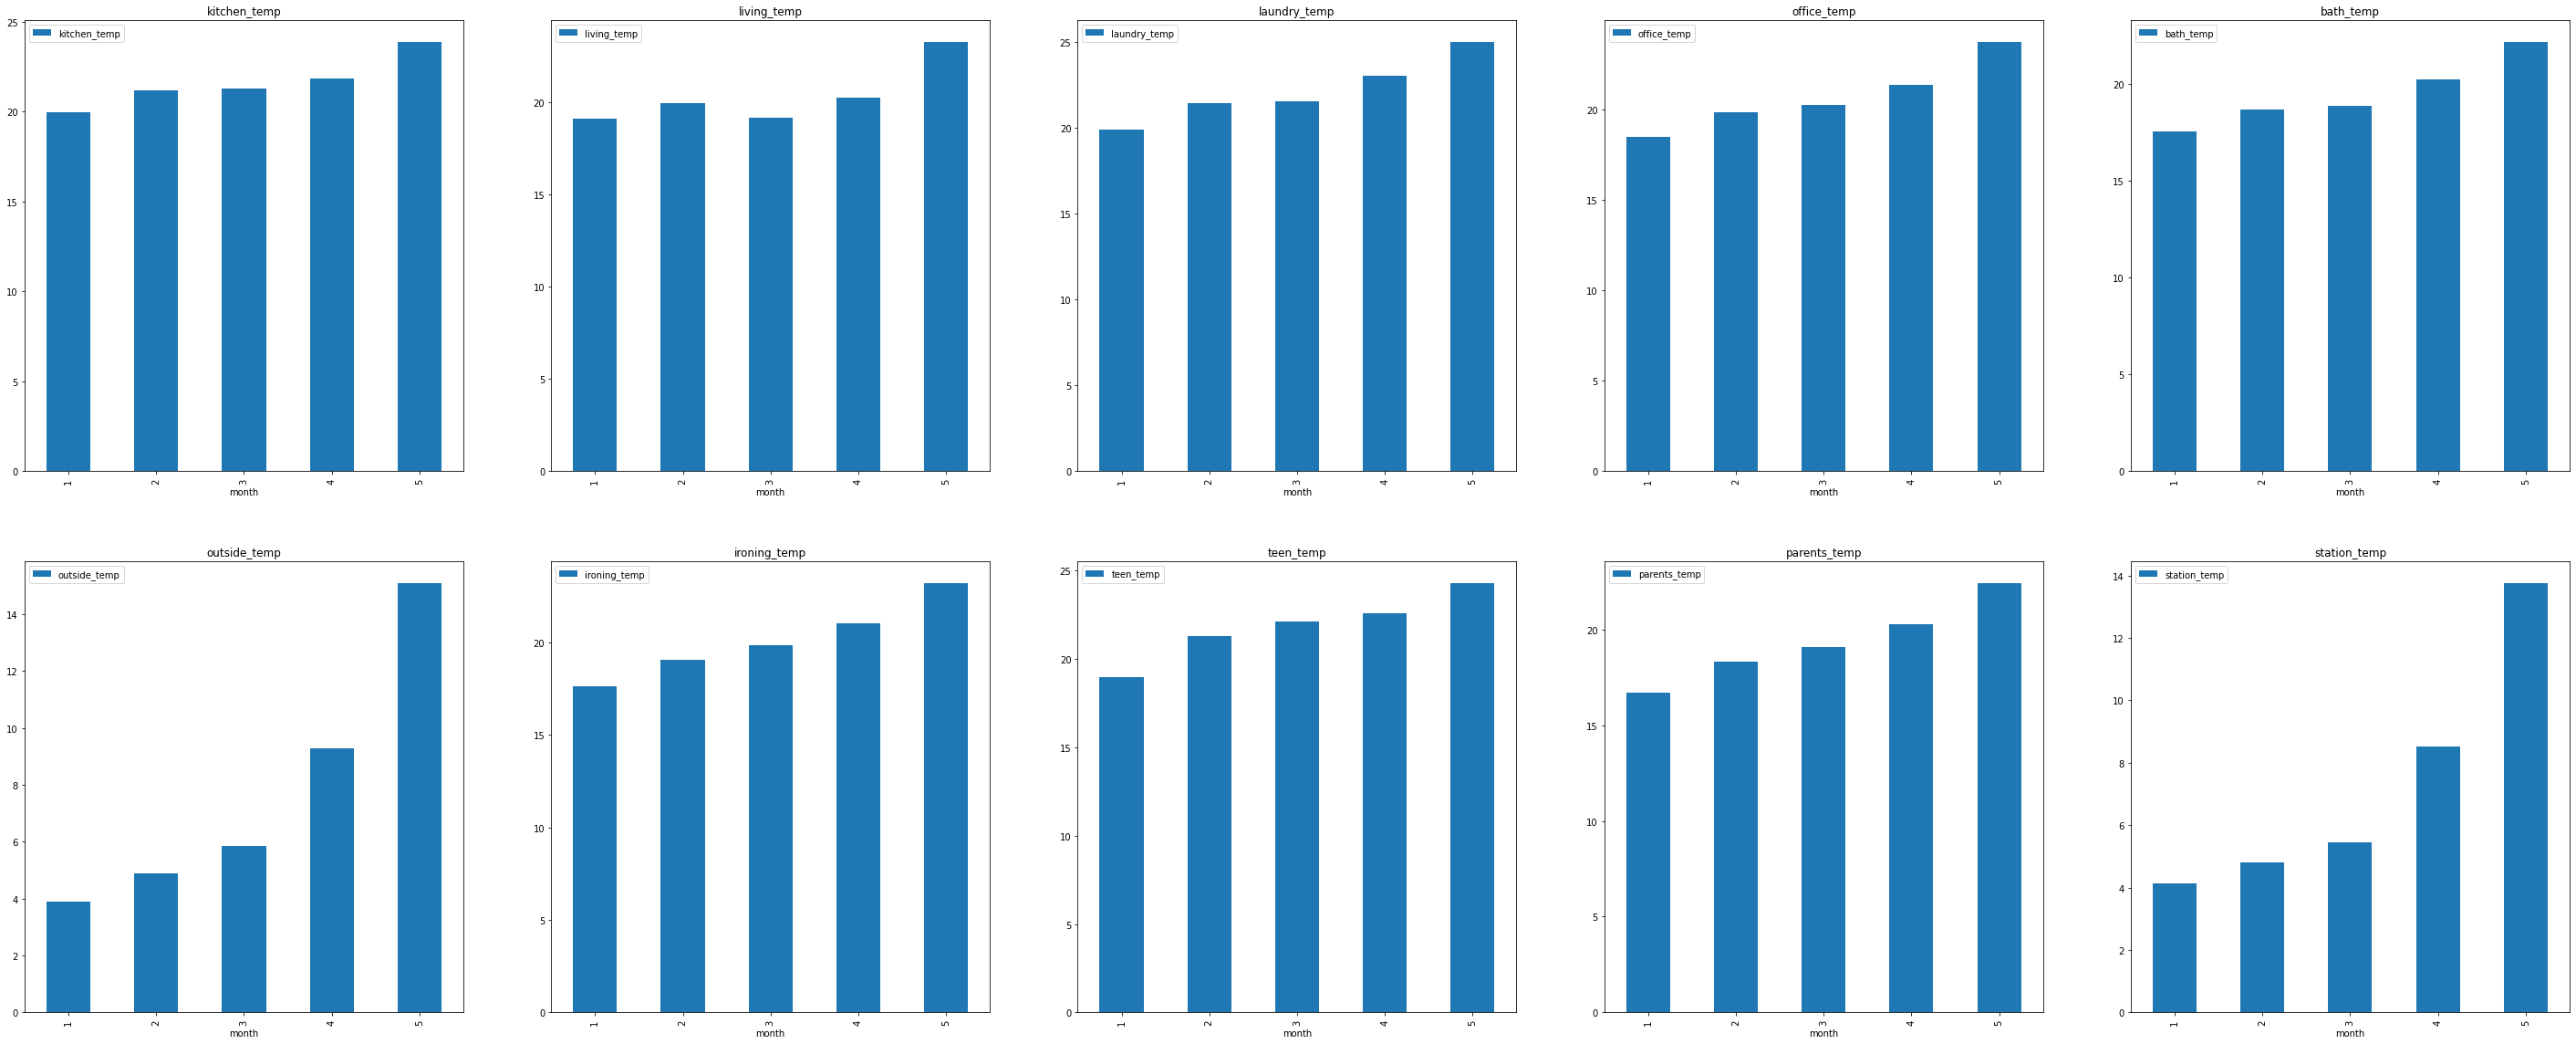

In [30]:
fig, axes = plt.subplots(2,5,figsize=(50,20))
for i, temp in enumerate(temp_dict.values()):
  energy_df.groupby('month').agg({temp : 'mean'}).plot.bar(ax=axes[i//5, i%5])
  axes[i//5, i%5].legend(loc='best')
  axes[i//5, i%5].set_title(temp)

In [31]:
temperatures_of_different_rooms = ['kitchen_temp','living_temp','laundry_temp', 
    'office_temp', 'bath_temp','outside_temp',
    'ironing_temp','teen_temp','parents_temp','station_temp', 'Appliances']

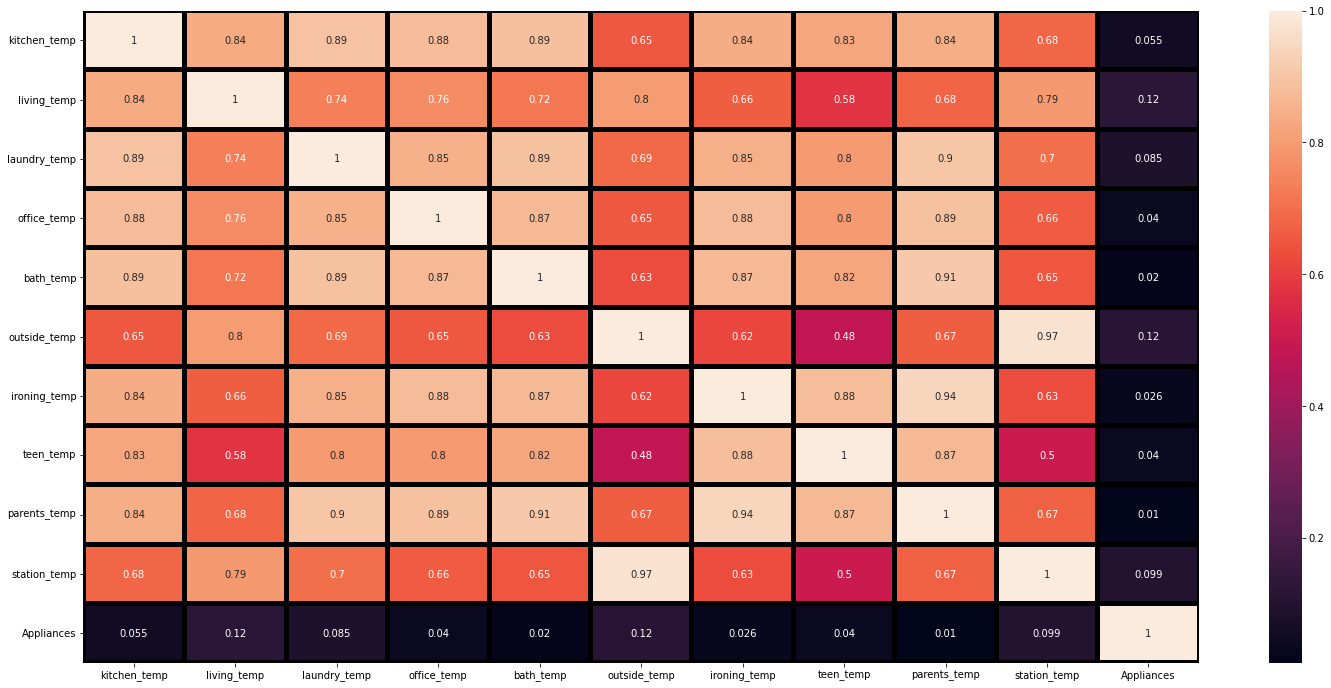

In [32]:
fig, ax = plt.subplots(figsize=(25,12))
sns.heatmap(energy_df[temperatures_of_different_rooms].corr(), annot = True, linewidths=4, linecolor='black')

OBSERVATION FROM TEMPERATURES

*Since parents_temp, teen_temp, and iroining_temp are highly correlated to each other and out of these teen_temp is highly correlated with Appliances so we take only teen_temp to final model

*Since kitchen_temp, living_temp, laundry_temp, office_temp and bath_temp are highly correlated to each other and out of these living_temp is highly correlated with Appliances so we take only teen_temp to final model
outside_temp is also highly correlated with appliances

In [33]:
humidities_of_different_rooms = ['kitchen_humid', 'living_humid', 'laundry_humid', 
    'office_humid','bath_humid', 'outside_humid',
    'ironing_humid', 'teen_humid', 'parents_humid', 'station_humid', 'Appliances']

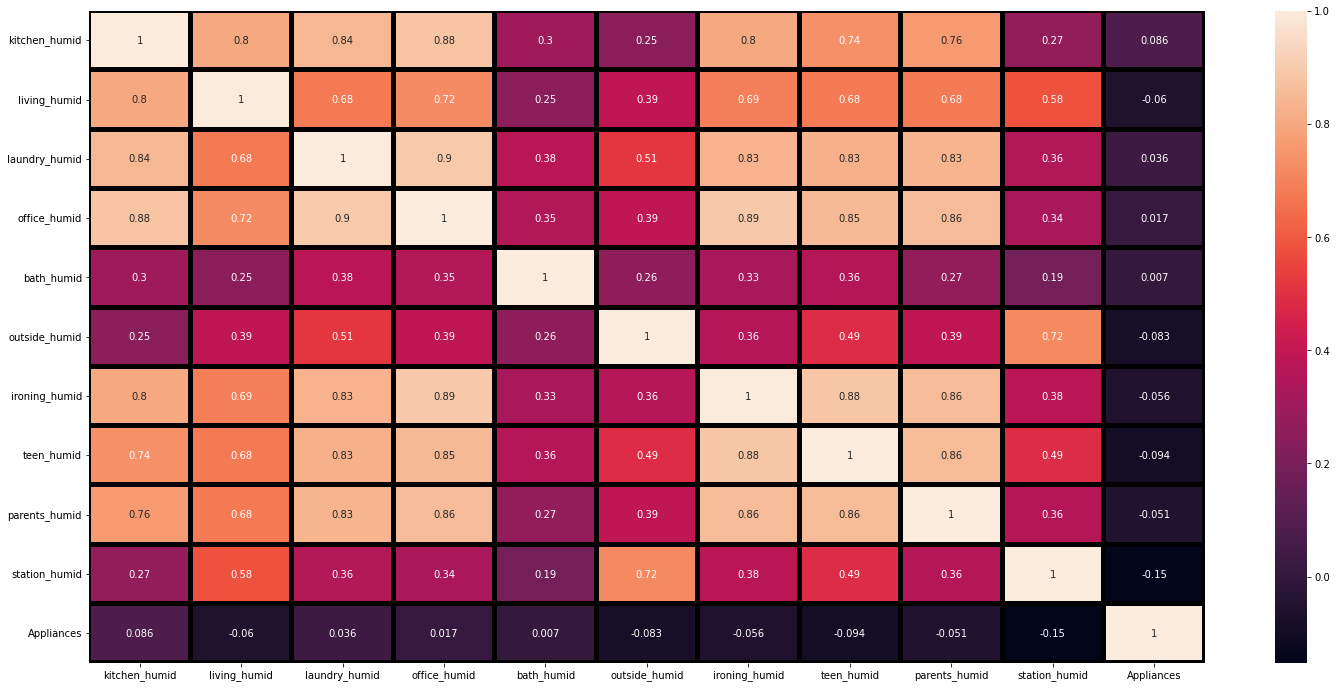

In [34]:
fig, ax = plt.subplots(figsize=(25,12))
sns.heatmap(energy_df[humidities_of_different_rooms].corr(), annot = True, linewidths=4, linecolor='black')

#Splitting Train and Test Set

In [132]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
from sklearn import neighbors
from sklearn.svm import SVR
import time
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [133]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from tensorflow.keras import Sequential, layers, Input

In [94]:
warnings.filterwarnings('ignore')

In [95]:
from sklearn.model_selection import train_test_split

# 75% of the data is usedfor the training of the models and the rest is used for testing
train, test = train_test_split(energy_df,test_size=0.25,random_state=40)

In [96]:
humid_dict.values()

dict_values(['kitchen_humid', 'living_humid', 'laundry_humid', 'office_humid', 'bath_humid', 'outside_humid', 'ironing_humid', 'teen_humid', 'parents_humid', 'station_humid'])

In [97]:
temp_dict.values()

dict_values(['kitchen_temp', 'living_temp', 'laundry_temp', 'office_temp', 'bath_temp', 'outside_temp', 'ironing_temp', 'teen_temp', 'parents_temp', 'station_temp'])

In [98]:
energy_df.columns

Index(['date', 'Appliances', 'kitchen_temp', 'kitchen_humid', 'living_temp',
       'living_humid', 'laundry_temp', 'laundry_humid', 'office_temp',
       'office_humid', 'bath_temp', 'bath_humid', 'outside_temp',
       'outside_humid', 'ironing_temp', 'ironing_humid', 'teen_temp',
       'teen_humid', 'parents_temp', 'parents_humid', 'station_temp',
       'Press_mm_hg', 'station_humid', 'Windspeed', 'Visibility', 'Tdewpoint',
       'rv1', 'rv2', 'weekday', 'hour', 'month'],
      dtype='object')

In [99]:
# Divide the columns based on type for clear column management 

col_temp = ['kitchen_temp', 'living_temp', 'laundry_temp', 'office_temp', 'bath_temp', 'outside_temp', 'ironing_temp', 'teen_temp', 'parents_temp']

col_hum = ['kitchen_humid', 'living_humid', 'laundry_humid', 'office_humid', 'bath_humid', 'outside_humid', 'ironing_humid', 'teen_humid', 'parents_humid']

col_weather = ['station_temp', 'Tdewpoint','station_humid',"Press_mm_hg",
                "Windspeed","Visibility"] 
col_light = ["lights"]

col_randoms = ["rv1", "rv2"]

col_target = ["Appliances"]

In [100]:
# Seperate dependent and independent variables 
feature_vars = train[col_temp + col_hum + col_weather]
target_vars = train[col_target]

In [101]:
#Split training dataset into independent and dependent varibales
X_train = train[feature_vars.columns]
y_train = train[target_vars.columns]

In [102]:
#Split testing dataset into independent and dependent varibales
X_test = test[feature_vars.columns]
y_test = test[target_vars.columns]

In [103]:
X_train.columns

Index(['kitchen_temp', 'living_temp', 'laundry_temp', 'office_temp',
       'bath_temp', 'outside_temp', 'ironing_temp', 'teen_temp',
       'parents_temp', 'kitchen_humid', 'living_humid', 'laundry_humid',
       'office_humid', 'bath_humid', 'outside_humid', 'ironing_humid',
       'teen_humid', 'parents_humid', 'station_temp', 'Tdewpoint',
       'station_humid', 'Press_mm_hg', 'Windspeed', 'Visibility'],
      dtype='object')

In [104]:
X_test.columns

Index(['kitchen_temp', 'living_temp', 'laundry_temp', 'office_temp',
       'bath_temp', 'outside_temp', 'ironing_temp', 'teen_temp',
       'parents_temp', 'kitchen_humid', 'living_humid', 'laundry_humid',
       'office_humid', 'bath_humid', 'outside_humid', 'ironing_humid',
       'teen_humid', 'parents_humid', 'station_temp', 'Tdewpoint',
       'station_humid', 'Press_mm_hg', 'Windspeed', 'Visibility'],
      dtype='object')

In [105]:
print(X_train.shape)
print(X_test.shape)

(14801, 24)
(4934, 24)


In [106]:
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [107]:
sc_y = StandardScaler()
y_train = sc_y.fit_transform(y_train.values.reshape([-1,1])).flatten()
y_test = sc_y.transform(y_test.values.reshape([-1,1])).flatten()

In [117]:
r2_val = []
rmse_val =[]

In [118]:
#Evalution Metrics
#function for model scored
def model_scores(model,xtest,ytest):

  #r2score
  r2 =  metrics.r2_score(ytest,model.predict(xtest))

  #root mean squared error
  rmse = sqrt(mean_squared_error(ytest,model.predict(xtest)))

  #accuracy
  acc = 100 - (100 * np.mean(abs(model.predict(xtest) - ytest)/ytest))
  print('\n\n\nfor' , model)
  print('\n\n\nr2 score is', r2)
  print('rmse score is', rmse)
  print('accuracy is', acc , '% \n\n\n')
  accuracy.append(acc)
  r2_val.append(r2)
  rmse_val.append(rmse)

#XGBOOST

In [121]:
model_name =[]

In [125]:
xgb = xgb.XGBRegressor()
xgb.fit(X_train, y_train)
model_scores(xgb,X_test,y_test)
model_name.append('xgb')

[15:19:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



for XGBRegressor()



r2 score is 0.2423670066799818
rmse score is 0.8567146706478532
accuracy is 87.98048776821959 % 





#Linear Regression

In [127]:
LinearRegression.score(X_test, y_test)

0.13475556547191114

In [139]:
y_pred=LinearRegression.predict(X_test)

In [140]:
r2_score(y_test, y_pred)

0.13475556547191114

In [156]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [157]:
regressor.intercept_

-2.662206308525692e-15

In [158]:
regressor.coef_

array([-0.00296823, -0.46008951,  0.50348801,  0.06616112, -0.01218331,
        0.45531222,  0.00205589,  0.21893972, -0.41526965,  0.62488674,
       -0.59647718,  0.16774734,  0.1018053 ,  0.01519432,  0.08833811,
       -0.06806866, -0.30868589, -0.06085231, -0.51066166,  0.15865594,
       -0.11326963,  0.01135919,  0.05298214,  0.02301275])

['***kitchen_temp***', 'living_temp', 'laundry_temp', '***office_temp***',
      '***bath_temp***', 'outside_temp', '***ironing_temp***', 'teen_temp',
       'parents_temp', 'kitchen_humid', 'living_humid', 'laundry_humid',
       'office_humid', '***bath_humid***', '***outside_humid***', '***ironing_humid***',
       'teen_humid', '***parents_humid***', 'station_temp', 'Tdewpoint',
       'station_humid', '***Press_mm_hg***', '***Windspeed***', '***Visibility***'], 
     

In [162]:
Dr=['living_temp', 'laundry_temp', 'outside_temp', 'teen_temp', 'parents_temp',
'kitchen_humid', 'living_humid', 'laundry_humid', 'office_humid', 'teen_humid','station_temp', 'Tdewpoint', 'station_humid']

In [165]:
df_new=energy_df[Dr]

In [166]:
df_new.columns

Index(['living_temp', 'laundry_temp', 'outside_temp', 'teen_temp',
       'parents_temp', 'kitchen_humid', 'living_humid', 'laundry_humid',
       'office_humid', 'teen_humid', 'station_temp', 'Tdewpoint',
       'station_humid'],
      dtype='object')

In [168]:
X=df_new
y=energy_df['Appliances']

In [169]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.33)


In [173]:
regressor1 = LinearRegression()
regressor1.fit(X_train1, y_train1)

LinearRegression()

In [174]:
y_pred1=regressor1.predict(X_test1)

In [175]:
r2_score(y_test1, y_pred1)

0.14483761914218196

In [180]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test1, y_pred1)

9097.152694132346

#95.3%

In [128]:
from sklearn.linear_model import LinearRegression 
LinearRegression= LinearRegression()
LinearRegression.fit(X_train, y_train)
model_scores(LinearRegression,X_test,y_test)
model_name.append('linearregression')





for LinearRegression()



r2 score is 0.13475556547191114
rmse score is 0.9155375720644787
accuracy is 77.4595681802438 % 





In [153]:
from sklearn import linear_model
lasso_reg = linear_model.Lasso(alpha=60, max_iter=100, tol=0.1)
lasso_reg.fit(X_train, y_train)

Lasso(alpha=60, max_iter=100, tol=0.1)

In [154]:
lasso_reg.score(X_test, y_test)

-3.0695963193494435e-05

In [155]:
lasso_reg.score(X_train, y_train)

0.0

In [141]:
from sklearn.linear_model import ElasticNet
ElasticNet = ElasticNet()
ElasticNet.fit(X_train,y_train)
model_scores(ElasticNet,X_test,y_test)
model_name.append('ElasticNet')




for ElasticNet()



r2 score is -3.0695963193494435e-05
rmse score is 0.9842681452923456
accuracy is 146.4531820024321 % 





#Lasso Regression

In [116]:
lasso = Lasso()
lasso.fit(X_train,y_train)
model_scores(lasso,X_test,y_test)
model_name.append('lasso')




for Lasso()



r2 score is -3.0695963193494435e-05
rmse score is 0.9842681452923456
accuracy is 146.4531820024321 % 





#ExtraTreeRegressor


In [67]:
#from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
ExtraTreesRegressor= ExtraTreesRegressor()
ExtraTreesRegressor.fit(X_train, y_train)
model_scores(ExtraTreesRegressor,X_test,y_test)
model_name.append('ExtraTreesRegressor')




for ExtraTreesRegressor()



r2 score is 0.6476880746453901
rmse score is 0.5842119502274558
accuracy is 52.85790533205948 % 





#SVM

In [56]:
svr = SVR(kernel='rbf')
svr.fit(X_train, y_train)
model_scores(svr,X_test,y_test)
model_name.append('svr')




for SVR()



r2 score is 0.21397343302337823
rmse score is 0.8726204307916837
accuracy is 68.75301454785385 % 





#Random Forest

In [57]:
random_forest = RandomForestRegressor()
random_forest.fit(X_train, y_train)
model_scores(random_forest,X_test,y_test)
model_name.append('random_forest')




for RandomForestRegressor()



r2 score is 0.5882924275514102
rmse score is 0.6315404786442251
accuracy is 52.16100962505234 % 





In [68]:
#CONVERTING EVALUATION METRICES TO DATAFRAME
eval = pd.DataFrame({'model_name' :model_name,
                                'accuracy' : accuracy,
                                'r2_val' : r2_val , 
                                'rmse_val' : rmse_val})
eval

,model_name,accuracy,r2_val,rmse_val
0,xgb,87.980488,0.242367,0.856715
1,svr,68.753015,0.213973,0.872620
2,random_forest,52.161010,0.588292,0.631540
3,ExtraTreesRegressor,52.857905,0.647688,0.584212


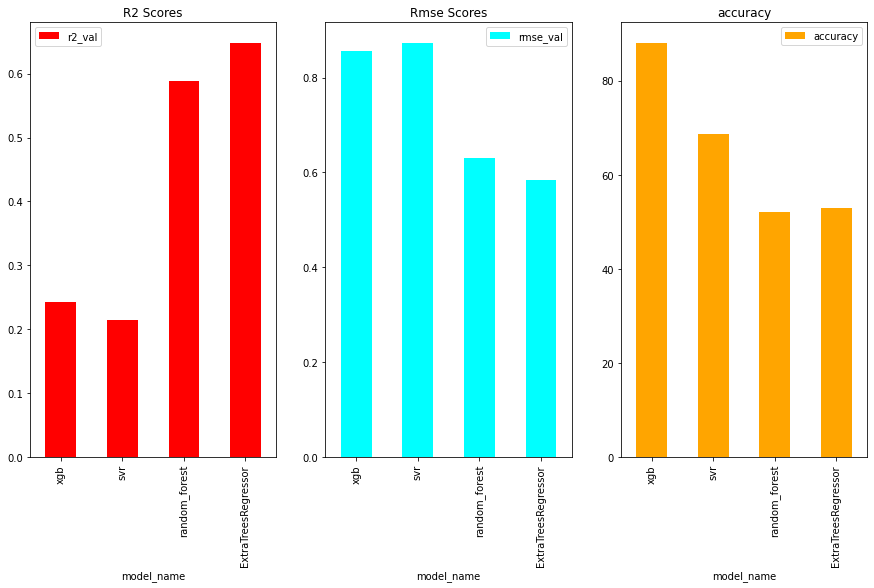

In [69]:
#PLOTTING R2 SCORES, RMSE AND ACCURACIES
fig,ax=plt.subplots(1,3, figsize=(15,8))
eval.plot(x='model_name', y='r2_val', kind="bar" , title = 'R2 Scores' ,ax=ax[0],color='red')
eval.plot(x='model_name', y='rmse_val', kind="bar" , title = 'Rmse Scores' ,ax=ax[1],color='cyan')
eval.plot(x='model_name', y='accuracy', kind="bar" , title = 'accuracy' ,ax=ax[2],color='orange')